# 3d models from photos and videos

There are any number of software packages that will take your photos and work out how the images overlap to combine into a 3d model. On your desktop, Windows users might want to look up 3DF Zephyr Free; Mac users can try Meshroom (but it's not for the faint of heart [link](https://alicevision.org/#meshroom))

A commercial service that will do the computation for you is [https://poly.cam/](https://poly.cam/); they have a free tier but can be aggressive with their pop-ups that try to nudge you into paying for things. Close the pop-ups, continue with the free tier.

In this notebook, I have gently modified the demonstration process of Florent Poux, who wrote: [https://towardsdatascience.com/master-the-3d-reconstruction-process-step-by-step-guide/](https://towardsdatascience.com/master-the-3d-reconstruction-process-step-by-step-guide/). 

**The goal for this notebook is to show you how the process works**. Remember those pictures you took way back in week 3? We'll talk about those in a moment once you've seen how the magic works.


In [1]:
# preliminaries
# we need a library meant to manipulate image data
!pip install opencv-python

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---- ----------------------------------- 4.5/39.0 MB 33.6 MB/s eta 0:00:02
   ---------------- ----------------------- 15.7/39.0 MB 45.0 MB/s eta 0:00:01
   -------------------------- ------------- 25.4/39.0 MB 47.3 MB/s eta 0:00:01
   ------------------------------------ --- 35.9/39.0 MB 48.5 MB/s eta 0:00:01
   ---------------------------------------- 39.0/39.0 MB 44.3 MB/s eta 0:00:00


In [23]:
## Let's grab a fun set of test images
## Sceaux Castle in France!
import os
import urllib.request

# Create the images directory
os.makedirs('images', exist_ok=True)

# Base URL pattern
base_url = 'https://github.com/openMVG/ImageDataset_SceauxCastle/blob/master/images/100_71{:02d}.JPG?raw=t'


# Loop through 100_7100.JPG to 100_7110.JPG
for i in range(11):  # 0 to 10 inclusive
    url = base_url.format(i)
    filename = f'images/100_71{i:02d}.jpg'
    
    try:
        urllib.request.urlretrieve(url, filename)
        print(f"Downloaded: {filename}")
    except Exception as e:
        print(f"Failed to download image 100_71{i:02d}.jpg: {e}")

print("Download process completed!")

Downloaded: images/100_7100.jpg
Downloaded: images/100_7101.jpg
Downloaded: images/100_7102.jpg
Downloaded: images/100_7103.jpg
Downloaded: images/100_7104.jpg
Downloaded: images/100_7105.jpg
Downloaded: images/100_7106.jpg
Downloaded: images/100_7107.jpg
Downloaded: images/100_7108.jpg
Downloaded: images/100_7109.jpg
Downloaded: images/100_7110.jpg
Download process completed!


Now we need to find features in the images that can be used to build up our image, that we can track from one image to the next.

In [22]:
#%% SECTION 1: Natural Feature Extraction
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_features(image_path, feature_method='sift', max_features=2000):
    """
    Extract features from an image using different methods.
    """

    # Read the image in color and convert to grayscale
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image at {image_path}")
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Initialize feature detector based on method
    if feature_method.lower() == 'sift':
        detector = cv2.SIFT_create(nfeatures=max_features)
    elif feature_method.lower() == 'surf':
        # Note: SURF is patented and may not be available in all OpenCV distributions
        detector = cv2.xfeatures2d.SURF_create(400)  # Adjust threshold as needed
    elif feature_method.lower() == 'orb':
        detector = cv2.ORB_create(nfeatures=max_features)
    else:
        raise ValueError(f"Unsupported feature method: {feature_method}")
    
    # Detect and compute keypoints and descriptors
    keypoints, descriptors = detector.detectAndCompute(gray, None)
    
    # Create visualization
    img_with_features = cv2.drawKeypoints(
        img, keypoints, None, 
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    
    print(f"Extracted {len(keypoints)} {feature_method.upper()} features")
    
    return keypoints, descriptors, img_with_features

# now let's identify features in one of the images
image_path = "images/100_7100.jpg"  

# Extract features with different methods
kp_sift, desc_sift, vis_sift = extract_features(image_path, 'sift')
kp_orb, desc_orb, vis_orb = extract_features(image_path, 'orb')

ValueError: Could not read image at images/100_7100.jpg

Ok, but what does that mean? These are two different algorithms for identifying keypoints in an image. In an actual workflow we might try a variety of algorithms and then decide which one to move forward with. Let's see what difference the two algorithms make:

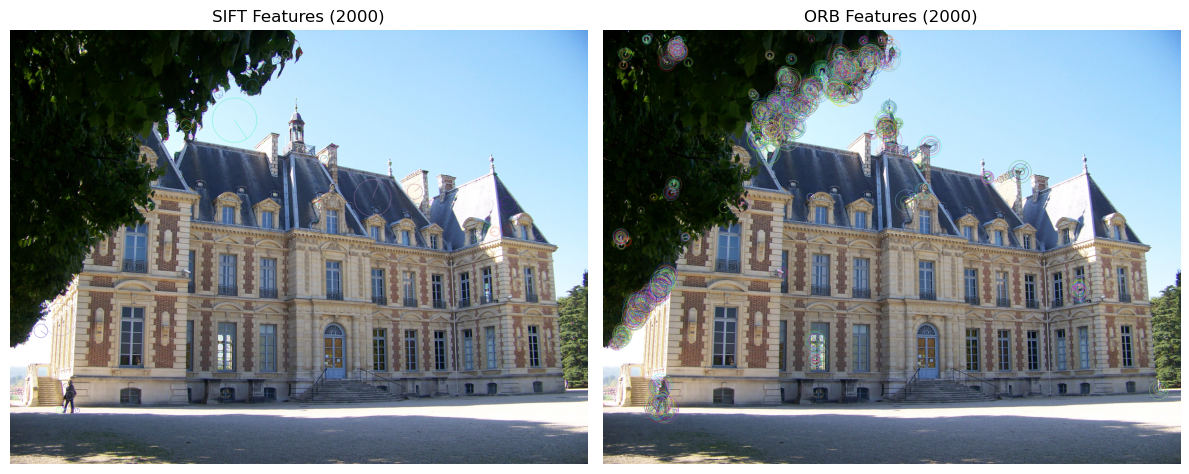

In [4]:
# Display results
plt.figure(figsize=(12, 6))
    
plt.subplot(1, 2, 1)
plt.title(f'SIFT Features ({len(kp_sift)})')
plt.imshow(cv2.cvtColor(vis_sift, cv2.COLOR_BGR2RGB))
plt.axis('off')
    
plt.subplot(1, 2, 2)
plt.title(f'ORB Features ({len(kp_orb)})')
plt.imshow(cv2.cvtColor(vis_orb, cv2.COLOR_BGR2RGB))
plt.axis('off')
    
plt.tight_layout()
plt.show()

Now we do that for every image, and then identify pairs of matching points across images.

In [5]:
#%% SECTION 2: Feature Matching
import cv2
import numpy as np
import matplotlib.pyplot as plt

def match_features(descriptors1, descriptors2, method='flann', ratio_thresh=0.75):
    """
    Match features between two images using different methods.
    """

    # Convert descriptors to appropriate type if needed
    if descriptors1 is None or descriptors2 is None:
        return []
    
    if method.lower() == 'flann':
        # FLANN parameters
        if descriptors1.dtype != np.float32:
            descriptors1 = np.float32(descriptors1)
        if descriptors2.dtype != np.float32:
            descriptors2 = np.float32(descriptors2)
            
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)  # Higher values = more accurate but slower
        
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    else:  # Brute Force
        # For ORB descriptors
        if descriptors1.dtype == np.uint8:
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
        else:  # For SIFT and SURF descriptors
            bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        
        matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = []
    for match in matches:
        if len(match) == 2:  # Sometimes fewer than 2 matches are returned
            m, n = match
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
    
    return good_matches

def visualize_matches(img1, kp1, img2, kp2, matches, max_display=100):
    """
    Create a visualization of feature matches between two images.
    """

    # Limit the number of matches to display
    matches_to_draw = matches[:min(max_display, len(matches))]
    
    # Create match visualization
    match_img = cv2.drawMatches(
        img1, kp1, img2, kp2, matches_to_draw, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    return match_img

# Load two images
img1_path = "images/100_7100.jpg"  
img2_path = "images/100_7101.jpg"
    
# Extract features using SIFT (or your preferred method)
kp1, desc1, _ = extract_features(img1_path, 'sift')
kp2, desc2, _ = extract_features(img2_path, 'sift')
    
# Match features
good_matches = match_features(desc1, desc2, method='flann')
    
print(f"Found {len(good_matches)} good matches")

Extracted 2000 SIFT features
Extracted 2000 SIFT features
Found 218 good matches


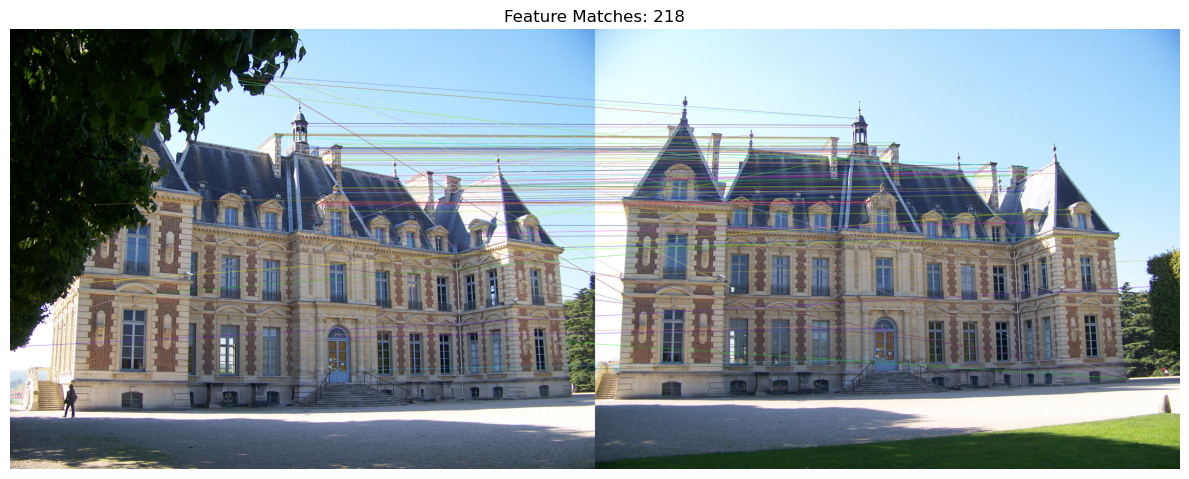

In [6]:
# Visualize matches
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
match_visualization = visualize_matches(img1, kp1, img2, kp2, good_matches)
    
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(match_visualization, cv2.COLOR_BGR2RGB))
plt.title(f"Feature Matches: {len(good_matches)}")
plt.axis('off')
plt.tight_layout()
plt.show()

Most of those look good, eh? But you can see that there are some bad matches. Ideally, we'd spend some time pruning those ones out. Do you see which ones I mean?

The next block uses this information to work out how much one image has moved (or rather, where the camera was for picture one versus picture two) so that the relative positioning of these points can be determined.

Extracted 2000 SIFT features
Extracted 2000 SIFT features
Estimated pose with 122 inliers out of 222 initial matches.


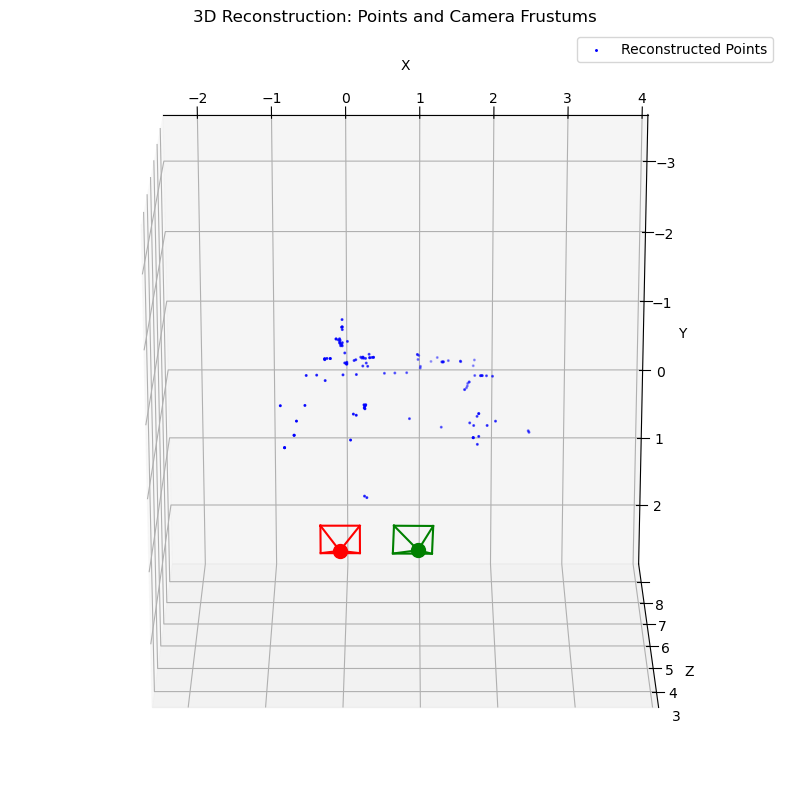

In [7]:
#%% SECTION 3: Structure from Motion 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def estimate_pose(kp1, kp2, matches, K, method=cv2.RANSAC, prob=0.999, threshold=1.0):
    """
    Estimate the relative pose between two cameras using matched features.
    This function now correctly filters matches using the essential matrix mask.
    """
    # Extract matched keypoints
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    # Estimate the Essential Matrix using RANSAC
    E, mask = cv2.findEssentialMat(pts1, pts2, K, method=method, prob=prob, threshold=threshold)
    
    if E is None:
        raise ValueError("Could not compute the Essential Matrix. Check your matches and K matrix.")
        
    # Recover the relative rotation (R) and translation (t) from the Essential Matrix
    _, R, t, mask = cv2.recoverPose(E, pts1, pts2, K, mask=mask)
    
    # Filter matches using the RANSAC mask to get only the inliers
    inlier_matches = [m for i, m in enumerate(matches) if mask[i]]
    
    print(f"Estimated pose with {len(inlier_matches)} inliers out of {len(matches)} initial matches.")
    
    return R, t, inlier_matches

def triangulate_points(kp1, kp2, matches, K, R1, t1, R2, t2):
    """
    Triangulate 3D points from two views using only the inlier matches.
    """
    # Extract matched keypoints from the inlier matches
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    # Create projection matrices for both cameras
    P1 = K @ np.hstack((R1, t1))
    P2 = K @ np.hstack((R2, t2))
    
    # Triangulate 3D points
    points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    
    # Convert from homogeneous to 3D coordinates by dividing by the 4th dimension
    points_3d = (points_4d_hom[:3] / points_4d_hom[3]).T
    
    return points_3d

def visualize_reconstruction(points_3d, R1, t1, R2, t2, K):
    """
    Visualize 3D points and camera frustums for a more intuitive view.
    """
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the 3D point cloud
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='b', marker='.', s=5, label='Reconstructed Points')
    
    # Helper function to plot a camera frustum
    def plot_camera_frustum(R, t, K, color, scale=0.5):
        # Camera center
        cam_center = -R.T @ t
        ax.scatter(cam_center[0], cam_center[1], cam_center[2], c=color, s=100, marker='o')

        # Frustum corners in image space (pixels)
        h, w = K[1, 2] * 2, K[0, 2] * 2 # Approximate image dimensions from K
        corners = np.array([
            [0, 0, 1],
            [w, 0, 1],
            [w, h, 1],
            [0, h, 1],
            [0, 0, 1] # Close the loop
        ])

        # Invert K to back-project points to normalized camera coordinates
        inv_K = np.linalg.inv(K)
        frustum_corners_cam = inv_K @ corners.T
        
        # Transform frustum from camera coordinates to world coordinates
        frustum_world = (R.T @ (frustum_corners_cam * scale)) - (R.T @ t)

        # Plot the frustum lines
        ax.plot(frustum_world[0, :], frustum_world[1, :], frustum_world[2, :], color=color) # Base
        for i in range(4): # Pyramidal lines
            ax.plot([cam_center[0,0], frustum_world[0, i]], 
                    [cam_center[1,0], frustum_world[1, i]], 
                    [cam_center[2,0], frustum_world[2, i]], color=color)

    # Plot the first camera (at the origin)
    plot_camera_frustum(R1, t1, K, 'red')
    
    # Plot the second camera
    plot_camera_frustum(R2, t2, K, 'green')
    
    ax.set_title('3D Reconstruction: Points and Camera Frustums')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    
    # Auto-scale axes to be equal
    max_range = np.array([points_3d[:,0].max()-points_3d[:,0].min(), 
                          points_3d[:,1].max()-points_3d[:,1].min(), 
                          points_3d[:,2].max()-points_3d[:,2].min()]).max()
    mid_x = (points_3d[:,0].max()+points_3d[:,0].min()) * 0.5
    mid_y = (points_3d[:,1].max()+points_3d[:,1].min()) * 0.5
    mid_z = (points_3d[:,2].max()+points_3d[:,2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    ax.view_init(elev=-70, azim=-90) # Better viewing angle
    plt.show()

# The Camera Intrinsic Matrix (K)
# Think of the K matrix as the camera's "fingerprint." 
# It's unique to a specific camera and lens combination and it allows us to translate 
# between the 2D pixel coordinates of an image and 3D rays in space. It looks like this:
#     [ [fx,  0, cx],
# K =  [ 0, fy, cy],
#      [ 0,  0,  1] ]
#    fx and fy are the focal lengths of the camera, but measured in pixel units. 
# They determine the "zoom" of the camera. cx and cy are the coordinates of the principal point, 
# which is the point where the central ray from the lens intersects the image sensor. 
# This is usually very close to the center of the image.

# For our purpose, the K below is a reasonable guess for a standard camera. 
# In a high-precision application, you would determine these values precisely 
# through a camera calibration process (e.g., taking pictures of a checkerboard). 
# Having an accurate K matrix is crucial for an accurate 3D reconstruction.

#img_height, img_width = 480, 640
#K = np.array([
#    [800, 0, img_width / 2],  # fx, 0, cx
#    [0, 800, img_height / 2], # 0, fy, cy
#    [0, 0, 1]
#])

# but actually, the dataset K values are available at https://github.com/openMVG/ImageDataset_SceauxCastle/blob/master/images/K.txt
K = np.array([
    [2905.88, 0, 1416],
    [0, 2905.88, 1064],
    [0, 0, 1]
])

# Define the first camera's pose as the world origin
R1 = np.eye(3)
t1 = np.zeros((3, 1))

# Load images, extract features, and match as in previous sections
img1_path = "images/100_7100.jpg"  # 
img2_path = "images/100_7101.jpg"

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

# Extract features and match them (as in previous sections)
kp1, desc1, _ = extract_features(img1_path, 'sift')
kp2, desc2, _ = extract_features(img2_path, 'sift')
initial_matches = match_features(desc1, desc2, method='flann')

# Estimate pose of the second camera and get geometrically verified inlier matches
R2, t2, inlier_matches = estimate_pose(kp1, kp2, initial_matches, K)

# Triangulate 3D points using ONLY the inlier matches
points_3d = triangulate_points(kp1, kp2, inlier_matches, K, R1, t1, R2, t2)

# Visualize the final 3D point cloud and camera poses
visualize_reconstruction(points_3d, R1, t1, R2, t2, K)

So ... doesn't look like a 3d model, eh? What we're seeing here is that the code has worked out the relative positioning of the two cameras for the two different images, and we can see the cloud of points that would anchor the eventual model. Since we also know where these points are in the original image, the image data can then be draped over top of the points and voilà, a 3d model from 2d photographs. We just need to tie it all together now.

Step 1: Initializing with the first two views...
Extracted 2000 SIFT features
Extracted 2000 SIFT features
Estimated pose with 128 inliers out of 217 initial matches.
Initialization complete. Map has 128 points. Initial baseline is 1.0000

--- Processing image 3/11: images\100_7102.jpg ---
Extracted 2000 SIFT features
Localization successful with 46 inliers.
Distance (0.71) exceeds threshold (0.40). CREATING NEW KEYFRAME.
Expanded map with 2000 new points.

--- Processing image 4/11: images\100_7103.jpg ---
Extracted 2000 SIFT features
Localization successful with 188 inliers.
Distance (0.40) exceeds threshold (0.40). CREATING NEW KEYFRAME.
Expanded map with 2000 new points.

--- Processing image 5/11: images\100_7104.jpg ---
Extracted 2000 SIFT features
Localization successful with 68 inliers.
Distance (0.56) exceeds threshold (0.40). CREATING NEW KEYFRAME.
Expanded map with 2000 new points.

--- Processing image 6/11: images\100_7105.jpg ---
Extracted 2000 SIFT features
Localization 

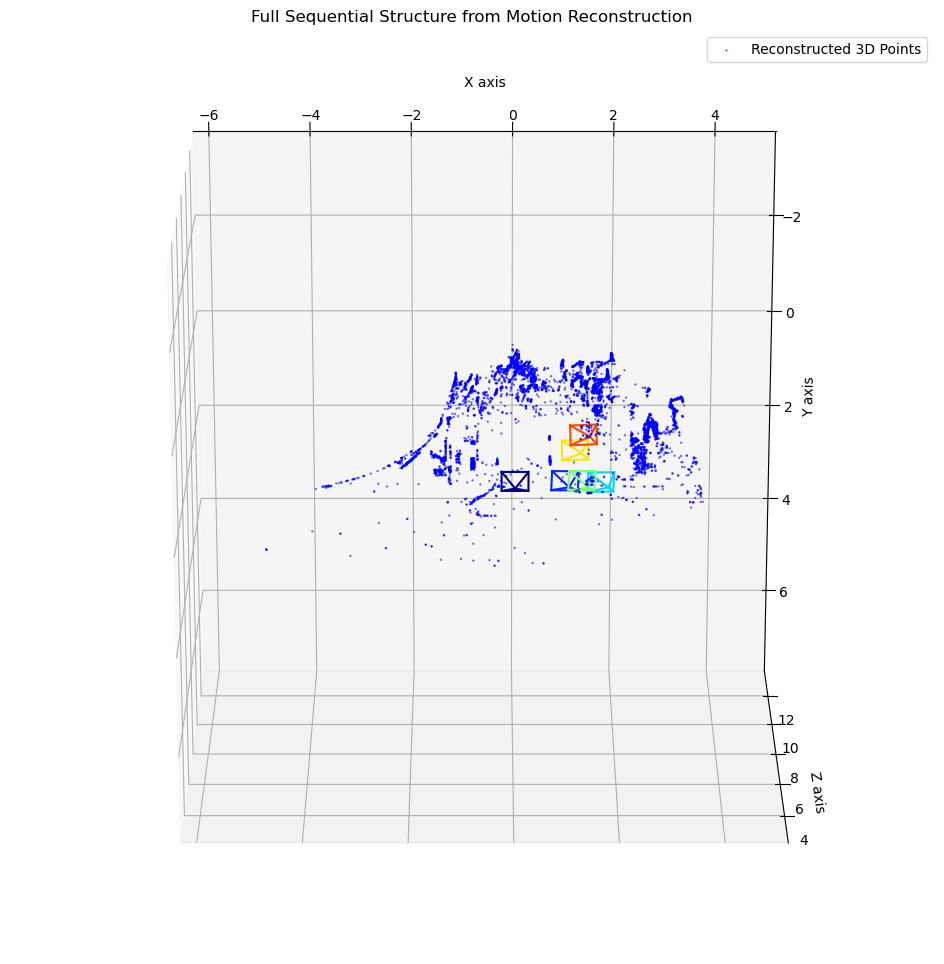


Points and Camera poses


In [8]:
#%% SECTION 4: Full Sequential Structure from Motion Pipeline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os


# --- Re-use previously defined functions ---
# extract_features, match_features, and the enhanced visualize_reconstruction 
# and other helper functions are defined in the earlier code blocks


# --- Configuration and Setup ---
IMAGE_DIR = "images"
image_files = sorted([os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg')])
K = np.array([[2905.88, 0, 1416], [0, 2905.88, 1064], [0, 0, 1]])

# --- Data storage ---
all_points_3d = np.zeros((0, 3))
map_point_descriptors = np.zeros((0, 128), dtype=np.float32)
keyframes = []

# --- 1. Initial Reconstruction (Bootstrap) ---
print("Step 1: Initializing with the first two views...")
img1_path, img2_path = image_files[0], image_files[1]
kp1, desc1, _ = extract_features(img1_path, 'sift')
kp2, desc2, _ = extract_features(img2_path, 'sift')
initial_matches = match_features(desc1, desc2, 'flann')
R_init, t_init, inlier_matches = estimate_pose(kp1, kp2, initial_matches, K)
if R_init is None: raise ConnectionError("Initial pose estimation failed.")

R1, t1 = np.eye(3), np.zeros((3, 1))
initial_points_3d = triangulate_points(kp1, kp2, inlier_matches, K, R1, t1, R_init, t_init)
all_points_3d = np.vstack((all_points_3d, initial_points_3d))

# Populate the initial map descriptors using the keypoints from the first image
for match in inlier_matches:
    map_point_descriptors = np.vstack((map_point_descriptors, desc1[match.queryIdx]))

# Create keyframes (now only storing pose and descriptors for map expansion)
first_keyframe = {'id': 0, 'pose': (R1, t1), 'keypoints': kp1, 'descriptors': desc1}
second_keyframe = {'id': 1, 'pose': (R_init, t_init), 'keypoints': kp2, 'descriptors': desc2}
keyframes.extend([first_keyframe, second_keyframe])

initial_baseline = np.linalg.norm(t_init)
print(f"Initialization complete. Map has {len(all_points_3d)} points. Initial baseline is {initial_baseline:.4f}")


MIN_TRANSLATION_THRESHOLD = initial_baseline * 0.40

# --- 2. Main Sequential Loop ---
all_camera_poses = [kf['pose'] for kf in keyframes]

for i in range(2, len(image_files)):
    print(f"\n--- Processing image {i+1}/{len(image_files)}: {image_files[i]} ---")
    
    img_new_path = image_files[i]
    kp_new, desc_new, _ = extract_features(img_new_path, 'sift')
    
    # Always match the new frame against the entire global map
    matches = match_features(desc_new, map_point_descriptors, 'flann')
    
    # We get direct 2D-to-3D correspondences from this match
    points_3d_for_pnp = np.array([all_points_3d[m.trainIdx] for m in matches])
    points_2d_for_pnp = np.array([kp_new[m.queryIdx].pt for m in matches])

    # Store which 3D point corresponds to which new keypoint for the map update
    map_indices = np.array([m.trainIdx for m in matches])
    kp_indices = np.array([m.queryIdx for m in matches])

    MIN_PNP_MATCHES = 15
    if len(matches) < MIN_PNP_MATCHES:
        print(f"Warning: Not enough map-to-frame matches ({len(matches)}). Skipping.")
        continue

    retval, R_vec, t_new, inliers = cv2.solvePnPRansac(points_3d_for_pnp, points_2d_for_pnp, K, None, flags=cv2.SOLVEPNP_EPNP)
    
    if not retval or len(inliers) < MIN_PNP_MATCHES:
        print(f"Warning: solvePnPRansac failed or has too few inliers. Skipping.")
        continue
        
    R_new, _ = cv2.Rodrigues(R_vec)
    current_pose = (R_new, t_new)
    all_camera_poses.append(current_pose)
    print(f"Localization successful with {len(inliers)} inliers.")
    
    # Decide if this frame should be a new keyframe to expand the map
    last_keyframe_pose = keyframes[-1]['pose']
    distance_moved = np.linalg.norm(t_new - last_keyframe_pose[1])
    
    if distance_moved > MIN_TRANSLATION_THRESHOLD:
        print(f"Distance ({distance_moved:.2f}) exceeds threshold ({MIN_TRANSLATION_THRESHOLD:.2f}). CREATING NEW KEYFRAME.")
        
        new_keyframe = {'id': i, 'pose': current_pose, 'keypoints': kp_new, 'descriptors': desc_new}
        keyframes.append(new_keyframe)
        
        # Match against the last keyframe to find brand-new points
        last_keyframe_kp = keyframes[-1]['keypoints']
        last_keyframe_desc = keyframes[-1]['descriptors']
        new_kf_matches = match_features(desc_new, last_keyframe_desc, 'flann')
        
        # We need to find which of these matches are TRULY new, and not already in our map
        # For simplicity, we triangulate all and add them, but a real system would filter duplicates
        R_kf_new, t_kf_new = new_keyframe['pose']
        R_kf_prev, t_kf_prev = last_keyframe_pose
        new_3d_points = triangulate_points(kp_new, last_keyframe_kp, new_kf_matches, K, R_kf_new, t_kf_new, R_kf_prev, t_kf_prev)
        
        reasonable_mask = (new_3d_points[:, 2] > 0) & (new_3d_points[:, 2] < 50)
        
        new_points_count = 0
        for j, match in enumerate(new_kf_matches):
            if reasonable_mask[j]:
                # Add the new 3D point to our global map
                all_points_3d = np.vstack((all_points_3d, [new_3d_points[j]]))
                # Add its descriptor to the global map descriptors
                map_point_descriptors = np.vstack((map_point_descriptors, desc_new[match.queryIdx]))
                new_points_count += 1

        print(f"Expanded map with {new_points_count} new points.")
        keyframes.append(new_keyframe)
    else:
        print(f"Distance ({distance_moved:.2f}) is below threshold. Not creating a keyframe.")



def plot_camera_frustum(ax, R, t, K, color, scale=0.5):
    """
    Draws a camera frustum in a 3D plot.
    
    Args:
        ax (matplotlib.axes._subplots.Axes3DSubplot): The 3D axes to draw on.
        R (np.ndarray): The 3x3 rotation matrix of the camera.
        t (np.ndarray): The 3x1 translation vector of the camera.
        K (np.ndarray): The 3x3 intrinsic matrix.
        color (str): The color for the frustum lines.
        scale (float): The scale of the frustum to make it visible.
    """
    # Get image dimensions from K (principal point is center)
    img_height = K[1, 2] * 2
    img_width = K[0, 2] * 2
    
    # Define the 4 corners of the image plane in pixel coordinates
    # The points are homogenous, with a z-coordinate of 1
    image_corners_pixels = np.array([
        [0, 0, 1],
        [img_width, 0, 1],
        [img_width, img_height, 1],
        [0, img_height, 1],
        [0, 0, 1]  # To close the rectangle
    ])
    
    # Invert the intrinsic matrix to back-project pixel coordinates to camera space
    inv_K = np.linalg.inv(K)
    
    # Back-project the corners to the camera's coordinate system (on the z=1 plane)
    frustum_corners_cam = inv_K @ image_corners_pixels.T
    
    # Scale the frustum for visualization
    frustum_scaled = frustum_corners_cam * scale
    
    # The camera center is at the origin of the camera's coordinate system
    # To get its world position, we use the inverse transformation: C = -R.T @ t
    camera_center_world = -R.T @ t
    
    # Transform the frustum corners from camera coordinates to world coordinates
    # P_world = R.T * P_cam + C
    frustum_world = R.T @ frustum_scaled + camera_center_world
    
    # Draw the base of the frustum
    ax.plot(frustum_world[0, :], frustum_world[1, :], frustum_world[2, :], color=color)
    
    # Draw the lines from the camera center to the frustum corners
    for i in range(4):
        ax.plot(
            [camera_center_world[0, 0], frustum_world[0, i]],
            [camera_center_world[1, 0], frustum_world[1, i]],
            [camera_center_world[2, 0], frustum_world[2, i]],
            color=color
        )

def visualize_full_reconstruction(points_3d, camera_poses, K):
    """
    Creates a 3D visualization of the entire reconstructed scene.
    
    Args:
        points_3d (np.ndarray): Nx3 array of 3D point coordinates.
        camera_poses (list): A list of (R, t) tuples for each camera.
        K (np.ndarray): The camera intrinsic matrix.
    """
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the 3D point cloud
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='blue', marker='.', s=2, alpha=0.5, label='Reconstructed 3D Points')
    
    # Plot each camera frustum
    for i, (R, t) in enumerate(camera_poses):
        # Use a colormap to give each camera a unique color
        color = plt.cm.jet(i / len(camera_poses))
        plot_camera_frustum(ax, R, t, K, color=color, scale=0.5)

    ax.set_title('Full Sequential Structure from Motion Reconstruction')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()
    
    # Set the aspect ratio of the plot to be equal
    # This is crucial for a correct interpretation of the 3D scene
    max_range = np.array([
        points_3d[:, 0].max() - points_3d[:, 0].min(),
        points_3d[:, 1].max() - points_3d[:, 1].min(),
        points_3d[:, 2].max() - points_3d[:, 2].min()
    ]).max() / 2.0

    mid_x = (points_3d[:, 0].max() + points_3d[:, 0].min()) * 0.5
    mid_y = (points_3d[:, 1].max() + points_3d[:, 1].min()) * 0.5
    mid_z = (points_3d[:, 2].max() + points_3d[:, 2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    # Set a nice viewing angle
    ax.view_init(elev=-70, azim=-90)
    
    plt.show()
print("\nStep 3: Generating final 3D reconstruction...")
# (The visualization function 'visualize_full_reconstruction' and its helper
# 'plot_camera_frustum' from the previous responses are assumed to be defined here)
visualize_full_reconstruction(all_points_3d, all_camera_poses, K)
print("\nPoints and Camera poses")

# ok, now to drape a texture

We take all those points, and create triangles from a point to its two closest points, until we have a mesh supported by the points. Then we drape the images on top of the mesh.

In [9]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist

def export_textured_mesh(
    all_points_3d, 
    keyframes, 
    image_files, 
    K,
    output_prefix="mesh_reconstruction",
    max_edge_length=2.0,
    texture_resolution=1024
):
    """
    Create a triangulated mesh with proper texture mapping from SfM data.
    
    Process:
    1. Create mesh topology using Delaunay triangulation
    2. Assign textures to faces based on viewing angles
    3. Create texture atlas with face-based UV mapping
    4. Export as proper textured OBJ/MTL
    """
    print(f"\nCreating textured mesh: {output_prefix}")
    
    obj_filename = f"{output_prefix}.obj"
    mtl_filename = f"{output_prefix}.mtl"
    
    # Load images
    images = load_keyframe_images(keyframes, image_files)
    if not images:
        print("ERROR: No valid images loaded!")
        return
    
    # Step 1: Create mesh topology
    faces, filtered_points = create_mesh_topology(all_points_3d, max_edge_length)
    if len(faces) == 0:
        print("ERROR: No valid faces created!")
        return
    
    print(f"Created mesh with {len(filtered_points)} vertices and {len(faces)} faces")
    
    # Step 2: Assign best camera to each face
    face_cameras = assign_cameras_to_faces(faces, filtered_points, keyframes, K)
    
    # Step 3: Create texture atlas and UV coordinates
    texture_filename, uv_coords = create_face_based_texture_atlas(
        faces, filtered_points, face_cameras, keyframes, images, K, 
        texture_resolution, output_prefix
    )
    
    # Step 4: Export mesh
    export_textured_mesh_obj(
        filtered_points, faces, uv_coords, 
        obj_filename, mtl_filename, texture_filename
    )
    
    print(f"Exported textured mesh: {obj_filename}")
    return {
        'obj_file': obj_filename,
        'mtl_file': mtl_filename, 
        'texture_file': texture_filename,
        'vertices': len(filtered_points),
        'faces': len(faces)
    }


def load_keyframe_images(keyframes, image_files):
    """Load and validate keyframe images."""
    images = {}
    for kf in keyframes:
        img_path = image_files[kf['id']]
        img = cv2.imread(img_path)
        if img is not None:
            images[kf['id']] = img
            print(f"Loaded image {kf['id']}: {img.shape}")
        else:
            print(f"Warning: Could not load {img_path}")
    return images


def create_mesh_topology(points_3d, max_edge_length):
    """
    Create mesh faces using 2.5D Delaunay triangulation.
    Projects points to dominant plane for triangulation.
    """
    print("Creating mesh topology...")
    
    # Filter out outlier points
    distances = np.linalg.norm(points_3d, axis=1)
    distance_threshold = np.percentile(distances, 95)
    valid_mask = distances < distance_threshold
    filtered_points = points_3d[valid_mask]
    
    if len(filtered_points) < 3:
        return [], []
    
    # Find dominant plane using PCA
    centered_points = filtered_points - np.mean(filtered_points, axis=0)
    _, _, V = np.linalg.svd(centered_points)
    
    # Project points onto the plane defined by first two principal components
    projected_2d = centered_points @ V[:2].T
    
    # Delaunay triangulation in 2D
    try:
        tri = Delaunay(projected_2d)
        triangles = tri.simplices
    except:
        print("Delaunay triangulation failed, using grid-based approach")
        return create_grid_based_mesh(filtered_points, max_edge_length)
    
    # Filter triangles by edge length in 3D
    valid_faces = []
    for triangle in triangles:
        p1, p2, p3 = filtered_points[triangle]
        
        edge1 = np.linalg.norm(p2 - p1)
        edge2 = np.linalg.norm(p3 - p2)
        edge3 = np.linalg.norm(p1 - p3)
        
        max_edge = max(edge1, edge2, edge3)
        
        # Also check triangle area to avoid degenerate triangles
        area = 0.5 * np.linalg.norm(np.cross(p2 - p1, p3 - p1))
        
        if max_edge < max_edge_length and area > 0.01:
            valid_faces.append(triangle)
    
    print(f"Created {len(valid_faces)} valid faces from {len(triangles)} triangles")
    return np.array(valid_faces), filtered_points


def create_grid_based_mesh(points_3d, max_edge_length):
    """
    Alternative mesh creation using nearest neighbor connections.
    More robust but creates more conservative connectivity.
    """
    print("Using grid-based mesh creation...")
    
    # Build nearest neighbor graph
    distances = cdist(points_3d, points_3d)
    faces = []
    
    for i in range(len(points_3d)):
        # Find nearby points
        nearby_indices = np.where((distances[i] > 0) & (distances[i] < max_edge_length))[0]
        
        if len(nearby_indices) >= 2:
            # Create triangles with current point and pairs of nearby points
            for j in range(len(nearby_indices) - 1):
                for k in range(j + 1, len(nearby_indices)):
                    idx1, idx2, idx3 = i, nearby_indices[j], nearby_indices[k]
                    
                    # Check if this forms a reasonable triangle
                    p1, p2, p3 = points_3d[[idx1, idx2, idx3]]
                    area = 0.5 * np.linalg.norm(np.cross(p2 - p1, p3 - p1))
                    
                    if area > 0.01:  # Avoid degenerate triangles
                        faces.append([idx1, idx2, idx3])
    
    return np.array(faces), points_3d


def assign_cameras_to_faces(faces, vertices, keyframes, K):
    """
    Assign the best camera/keyframe to each face based on viewing angle.
    """
    print("Assigning cameras to faces...")
    
    face_cameras = {}
    
    for face_idx, face in enumerate(faces):
        # Calculate face center and normal
        face_vertices = vertices[face]
        face_center = np.mean(face_vertices, axis=0)
        
        # Calculate face normal using cross product
        v1 = face_vertices[1] - face_vertices[0]
        v2 = face_vertices[2] - face_vertices[0]
        face_normal = np.cross(v1, v2)
        face_normal = face_normal / (np.linalg.norm(face_normal) + 1e-8)
        
        best_camera = None
        best_score = -1
        
        for kf in keyframes:
            R, t = kf['pose']
            
            # Transform face center to camera coordinates
            face_center_cam = R @ face_center.reshape(3, 1) + t
            
            # Skip if behind camera
            if face_center_cam[2] <= 0:
                continue
            
            # Project to check if face center is visible
            face_center_img = K @ face_center_cam
            u = face_center_img[0] / face_center_img[2]
            v = face_center_img[1] / face_center_img[2]
            
            # Assuming image dimensions from K matrix
            img_w, img_h = K[0, 2] * 2, K[1, 2] * 2
            
            if 0 <= u <= img_w and 0 <= v <= img_h:
                # Calculate viewing score
                viewing_direction = face_center_cam.flatten() / np.linalg.norm(face_center_cam)
                
                # Transform face normal to camera coordinates
                face_normal_cam = R @ face_normal
                
                # Score based on alignment with viewing direction and distance
                alignment = np.abs(np.dot(viewing_direction, face_normal_cam))
                distance = np.linalg.norm(face_center_cam)
                score = alignment / (distance + 1e-6)
                
                if score > best_score:
                    best_score = score
                    best_camera = kf['id']
        
        face_cameras[face_idx] = best_camera
    
    print(f"Assigned cameras to {len([c for c in face_cameras.values() if c is not None])} faces")
    return face_cameras


def create_face_based_texture_atlas(faces, vertices, face_cameras, keyframes, images, K, 
                                   texture_resolution, output_prefix):
    """
    Create texture atlas by packing face textures from their assigned cameras.
    """
    print("Creating texture atlas...")
    
    # Group faces by camera
    camera_faces = {}
    for face_idx, camera_id in face_cameras.items():
        if camera_id is not None:
            if camera_id not in camera_faces:
                camera_faces[camera_id] = []
            camera_faces[camera_id].append(face_idx)
    
    print(f"Grouped faces into {len(camera_faces)} camera groups")
    
    # Simple atlas layout: arrange camera textures in grid
    grid_size = int(np.ceil(np.sqrt(len(camera_faces))))
    atlas_size = texture_resolution * grid_size
    texture_atlas = np.zeros((atlas_size, atlas_size, 3), dtype=np.uint8)
    
    # UV coordinates for each vertex
    uv_coords = np.zeros((len(vertices), 2))
    
    camera_positions = {}
    pos_idx = 0
    
    for camera_id in camera_faces:
        if camera_id not in images:
            continue
            
        # Calculate atlas position for this camera
        row = pos_idx // grid_size
        col = pos_idx % grid_size
        atlas_x = col * texture_resolution
        atlas_y = row * texture_resolution
        camera_positions[camera_id] = (atlas_x, atlas_y)
        
        # Find keyframe for camera parameters
        kf = next((k for k in keyframes if k['id'] == camera_id), None)
        if kf is None:
            continue
            
        R, t = kf['pose']
        img = images[camera_id]
        img_h, img_w = img.shape[:2]
        
        # Resize image to fit atlas tile
        img_resized = cv2.resize(img, (texture_resolution, texture_resolution))
        texture_atlas[atlas_y:atlas_y+texture_resolution, 
                     atlas_x:atlas_x+texture_resolution] = img_resized
        
        # Calculate UV coordinates for faces using this camera
        for face_idx in camera_faces[camera_id]:
            face = faces[face_idx]
            
            for vertex_idx in face:
                vertex_3d = vertices[vertex_idx]
                
                # Project vertex to camera image
                vertex_cam = R @ vertex_3d.reshape(3, 1) + t
                if vertex_cam[2] > 0:
                    vertex_img = K @ vertex_cam
                    u_img = vertex_img[0] / vertex_img[2]
                    v_img = vertex_img[1] / vertex_img[2]
                    
                    # Convert to normalized texture coordinates within this camera's atlas tile
                    u_norm = float((u_img / img_w) * (texture_resolution / atlas_size) + (atlas_x / atlas_size))
                    v_norm = float((v_img / img_h) * (texture_resolution / atlas_size) + (atlas_y / atlas_size))
                    
                    # Clamp to valid range
                    u_norm = np.clip(u_norm, atlas_x/atlas_size, (atlas_x+texture_resolution)/atlas_size)
                    v_norm = np.clip(v_norm, atlas_y/atlas_size, (atlas_y+texture_resolution)/atlas_size)
                    
                    uv_coords[vertex_idx, 0] = float(u_norm)
                    uv_coords[vertex_idx, 1] = float(1.0 - v_norm)  # Flip V
        
        pos_idx += 1
    
    # Save texture atlas
    texture_filename = f"{output_prefix}_texture.jpg"
    cv2.imwrite(texture_filename, texture_atlas)
    print(f"Saved texture atlas ({atlas_size}x{atlas_size}) to {texture_filename}")
    
    return texture_filename, uv_coords


def export_textured_mesh_obj(vertices, faces, uv_coords, obj_filename, mtl_filename, texture_filename):
    """
    Export the textured mesh as OBJ/MTL files.
    """
    # Write MTL file
    with open(mtl_filename, 'w') as f:
        f.write("# Material file for textured mesh\n")
        f.write("newmtl TexturedMesh\n")
        f.write("Ka 1.0 1.0 1.0\n")
        f.write("Kd 1.0 1.0 1.0\n")
        f.write("Ks 0.0 0.0 0.0\n")
        f.write("d 1.0\n")
        f.write("illum 1\n")
        f.write(f"map_Kd {texture_filename}\n")
    
    # Write OBJ file
    with open(obj_filename, 'w') as f:
        f.write("# Textured mesh from Structure from Motion\n")
        f.write(f"mtllib {mtl_filename}\n\n")
        
        # Write vertices
        f.write("# Vertices\n")
        for vertex in vertices:
            f.write(f"v {vertex[0]:.6f} {vertex[1]:.6f} {vertex[2]:.6f}\n")
        
        # Write texture coordinates
        f.write("\n# Texture coordinates\n")
        for uv in uv_coords:
            f.write(f"vt {uv[0]:.6f} {uv[1]:.6f}\n")
        
        # Write faces with texture coordinates
        f.write("\nusemtl TexturedMesh\n")
        f.write("# Faces\n")
        for face in faces:
            # OBJ uses 1-based indexing
            v1, v2, v3 = face + 1
            f.write(f"f {v1}/{v1} {v2}/{v2} {v3}/{v3}\n")
    
    print(f"Exported textured mesh to {obj_filename}")


In [25]:
result = export_textured_mesh(
     all_points_3d,
     keyframes,
     image_files,
     K,
     "castle_mesh",
     max_edge_length=2.0,
     texture_resolution=512
 )


Creating textured mesh: castle_mesh
Loaded image 0: (2128, 2832, 3)
Loaded image 1: (2128, 2832, 3)
Loaded image 2: (2128, 2832, 3)
Loaded image 2: (2128, 2832, 3)
Loaded image 3: (2128, 2832, 3)
Loaded image 3: (2128, 2832, 3)
Loaded image 4: (2128, 2832, 3)
Loaded image 4: (2128, 2832, 3)
Creating mesh topology...
Created 879 valid faces from 9160 triangles
Created mesh with 5820 vertices and 879 faces
Assigning cameras to faces...
Assigned cameras to 879 faces
Creating texture atlas...
Grouped faces into 5 camera groups
Saved texture atlas (1536x1536) to castle_mesh_texture.jpg
Exported textured mesh to castle_mesh.obj
Exported textured mesh: castle_mesh.obj


C:\Users\monke\AppData\Local\Temp\ipykernel_19908\2685265160.py:295: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_norm = float((u_img / img_w) * (texture_resolution / atlas_size) + (atlas_x / atlas_size))
C:\Users\monke\AppData\Local\Temp\ipykernel_19908\2685265160.py:296: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v_norm = float((v_img / img_h) * (texture_resolution / atlas_size) + (atlas_y / atlas_size))


So that's more or less how it all works. You take the .obj, .mtl, and the texture.jpg files and zip those up. Then, you can upload them to a 3d object viewer like sketchfab.com. Or go to [https://3dviewer.net/](https://3dviewer.net/) and drag the .obj, .mtl, and the texture jpg onto the screen.

Our castle looks a bit ... trippy. And that's because I haven't bothered to figure out yet all the niggling details that would resolve the outliers and odd bits of data artefacts. Because the approach here is meant to show you the basic logic and flow, the final output isn't as nice as a more robust dataset and approach might create.

Compare the result with what you might get with an older piece of software called [Regard3d](https://www.regard3d.org/index.php/download). It bundles all of the steps we've done here together into a user interface and critically, shows you the output of each step and allows you to play with all the possible variables so that you can address the issues visible in our result here. Windows users might try [Zephyr Free](https://www.3dflow.net/3df-zephyr-free/); there are plenty of apps for IOS and Android, if you want to try things that way.

A more technically sophisticated technique is 'gaussian splatting', which takes a video as input. The technique uses a kind of neural network approach for rendering the data. Essentially, while the sfm approach we used here identifies points in the images, gaussian splatting considers each point as a whole distribution of values. You can imagine what the math would be like. The upshot is you get much better results that aren't as fragile as the sfm approach. You can give it a try [with this google colab notebook](https://colab.research.google.com/github/benyoon1/gaussian-splat-colab/blob/main/gsplat_colab_template.ipynb#scrollTo=Jg-_TYBaJkcD). Here's some [introductory material explaining the main idea](https://huggingface.co/blog/gaussian-splatting). And as it happens, [poly.cam](https://poly.cam) can do both approaches so you can see the difference for yourself.



# Your turn
Make a folder in the week 10 workbench. Put your photos from the graveyard in there. Make a copy of these notebook, then open it. Go back to the section 1 of the notebook and change the data input to point to your folder of images (so not the download cells, right!). Work through the notebook again, but swapping in your data at each step. See how it goes.

Then, go try [poly.cam](https://poly.cam/). You can get a free account and use their platform to turn both images and videos into photogrammetric sfm models _or_ guassian splats - but be careful to not get upsold beyond the free tier. These folks have professional developers working on making their algorithms the best in the business, so you'll definitely get better results than my code, as long as your input images have sufficient overlap. Use your images and videos you captured when you were at the graveyard. Download a model it makes and put it in your github repository. Evaluate the quality of your model. What might your model be *good for*?

Also - explore the poly.cam interface carefully. If a model is built right, you can actually read measurements and dimensions from the 3d model, and that is certainly handy for communicating the results of your research or making it useful for others.